# K-Nearest Neighbors

We use KNNs to create a model that directly predicts a class for a new data point based off of the features. We'll also introduce metric learning to improve the performance of KNN classifiers by constructing informed distance metric.

## Basics

Although KNNs use labelled data for inference, **they do not go through any training process because there are no model parameters to learn.** KNNs can be used for both classification (`KNeighborsClassifier`) and regression (`KNeighborsRegressor`) tasks.

Given a labeled dataset $\{(x_i, y_i)\}_{i=1}^n$ and a sample $x$ to be predicted:

1. Select a value $K$ and a **distance function**

2. Compute the distance between $x$ and the $n$ training samples

3. Take the $K$-nearest data samples, known as $K$-nearest neighbors

4. - Classification: assign $x$ to the class that has the greatest number of its $K$-nearest neighbors
   - Regression: average the target values of its $K$-nearest neighbors

<img src='../figs/08_KNN.png' width = '300'>

KNN's performance is influenced by 

* The **distance function** used to determine the nearest neighbors

* **number of nearest neighbors** taken into account, i.e. value of $K$, used to classify  new samples


In the case where variables have very different measurement scales, then one variable will have a much higher influence on the distance calculated than another, e.g., one variable is based on annual income in dollars, and the other is based on age in years. We need to **standardize** the data (training and testing) so that features are on the same scale.

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Get the Data

Set index_col=0 to use the first column as the index.

In [25]:
df = pd.read_csv("KNN_Dataset")
df

,Unnamed: 0,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1.010953,1.034006,0.853116,0.622460,1.036610,0.586240,0.746811,0.319752,1.117340,1.348517,1
996,996,0.575529,0.955786,0.941835,0.792882,1.414277,1.269540,1.055928,0.713193,0.958684,1.663489,0
997,997,1.135470,0.982462,0.781905,0.916738,0.901031,0.884738,0.386802,0.389584,0.919191,1.385504,1
998,998,1.084894,0.861769,0.407158,0.665696,1.608612,0.943859,0.855806,1.061338,1.277456,1.188063,1


In [26]:
df = pd.read_csv("KNN_Dataset", index_col=0)

In [27]:
df.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [28]:
df.shape[0]

1000

## Standardize the Variables

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will have a much larger effect on the distance between the observations, and hence on the KNN classifier, than variables that are on a small scale.

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [30]:
scaler.fit(df.drop('TARGET CLASS',axis=1))

StandardScaler()

In [31]:
scaled_features = scaler.transform(df.drop('TARGET CLASS',axis=1))

In [32]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


## Train Test Split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['TARGET CLASS'],
                                                    test_size=0.30, random_state=101)

## Using KNN

Remember that we are trying to come up with a model to predict whether someone will TARGET CLASS or not. 

In [35]:
from sklearn.neighbors import KNeighborsClassifier

For KNN algorithm, there are two important factors: the number of nearest neighbors and the metric or norm used for measure the distance, i.e., $\ell_p$ norm ($p\geq1$)

* Euclidean:  $\|x-z\|:=\sqrt{\sum_{i=1}^d  (x_i - z_i)^2 }$, $(p=2)$

* Manhattan: $\|x-z\|_1:=\sum_{i=1}^d  |x_i - z_i|$, $(p=1)$

* Minkowski: $\|x-z\|_p := \left(\sum_{i=1}^d  (x_i - z_i)^p \right)^{1/p}$ 

In [36]:
knn = KNeighborsClassifier(n_neighbors=1) # default: Euclidean distance, i.e., p=2

In [37]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [38]:
pred = knn.predict(X_test)

## Predictions and Evaluations

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
print('K=1')
# confusion matrix: [ [#TP, #FP], [#FN, #TN] ] 
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

K=1
[[151   8]
 [ 15 126]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       159
           1       0.94      0.89      0.92       141

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



## Choosing a K Value

Do a for loop to pick a good K Value:

In [41]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test)) # misclassification rate

Text(0, 0.5, 'Error Rate')

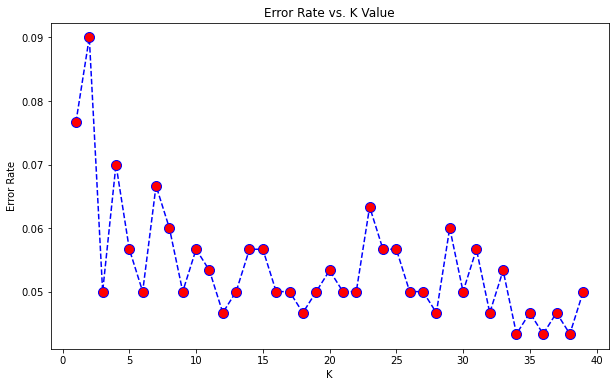

In [42]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Here we can see that the error rate tends to hover around 0.05-0.07

In [43]:
# The best K = 34
knn = KNeighborsClassifier(n_neighbors=34)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('The best K = 34')
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

The best K = 34
[[153   6]
 [  7 134]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       159
           1       0.96      0.95      0.95       141

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



## Large Margin Nearest Neighbor

[Large Margin Nearest Neighbor](https://en.wikipedia.org/wiki/Large_margin_nearest_neighbor) (LMNN) belongs to the class of metric learning. The goal of supervised metric learning algorithms is to transform points in a new space, in which 

* the distance between two points from the same class will be small

* the distance between two points from different classes will be large.

LMNN learns a **Mahalanobis distance** metric in the KNN classification setting. The learned metric attempts to keep close k-nearest neighbors from the same class, while keeping examples from different classes separated by a large margin. This algorithm makes no assumptions about the distribution of the data. **You'll need to first install the ``metric_learn`` library.**

A **Mahalanobis distance** metric is induced by some matrix $\mathbf{D}$:

$$
d_M(\mathbf{x}, \mathbf{z}) = \|\mathbf{D}(\mathbf{x} - \mathbf{z})\|
$$

<img src='../figs/08_Lmnn.png' width =  '600'>

The distance matrix, i.e. $\mathbf{D}\in\mathbb{R}^{d\times d}$, is learned by solving the following optimization problem:

$$
\min_{\mathbf{D}\in\mathbb{R}^{d\times d}} \sum_{i}\sum_{j\in\mathcal{N}(i)} \eta_{i,j} \|\mathbf{D}(\mathbf{x}_i - \mathbf{x}_j)\|^2 + c \sum_{i}\sum_{j,l\in\mathcal{N}(i)} \eta_{i,j} (1-\eta_{i,l})\left[ 1+ \|\mathbf{D}(\mathbf{x}_i - \mathbf{x}_j)\|^2 - \|\mathbf{D}(\mathbf{x}_i - \mathbf{x}_l)\|^2\right]_+
$$

where $\mathbf{x}_i$ is a data point, $\mathbf{x}_j$ is one of its K-nearest neighbors sharing the same label, and $\mathbf{x}_l$ is any instance within that region with different label, $\eta_{i,j}\in\{0,1\}$ is the indicator, $\eta_{i,j} = 1$ represents $\mathbf{x}_j$ is the K-nearest neighbors (with same labels) of $\mathbf{x}_i$, $\eta_{i,l}=0$ indicates $\mathbf{x}_i$, $\mathbf{x}_l$ belong to different classes, $[\cdot]_+ = \max(0,\cdot)$ is the hinge loss.

* The first optimization goal is achieved by minimizing the average distance between instances and their target neighbors of the same class.

* The second goal is achieved by penalizing distances to $\mathbf{x}_l$ that are less than one unit further away than to target neighbors $\mathbf{x}_j$ (and therefore pushing them out of the local neighborhood of $\mathbf{x}_i$).

In [ ]:
import numpy as np
from metric_learn import LMNN 

In [44]:
lmnn = LMNN(k=5, learn_rate=1e-6)
lmnn.fit(X_train, y_train)

LMNN(k=5, learn_rate=1e-06)

In [45]:
print(lmnn.get_metric())

<function MahalanobisMixin.get_metric.<locals>.metric_fun at 0x7f78ad41e1f0>


In [46]:
knn = KNeighborsClassifier(n_neighbors=5, metric=lmnn.get_metric())
knn.fit(X_train,y_train)

pred = knn.predict(X_test)

print('K=5')
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

K=5
[[154   5]
 [ 11 130]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       159
           1       0.96      0.92      0.94       141

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



Text(0, 0.5, 'Error Rate')

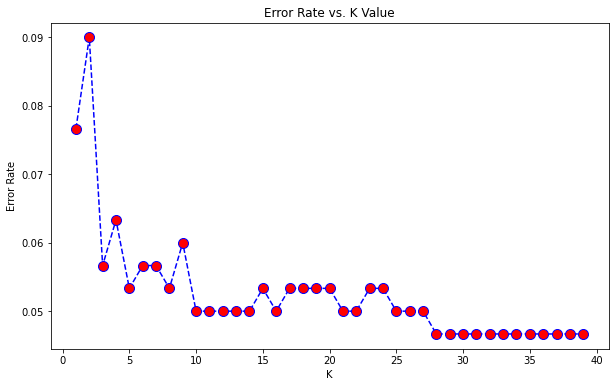

In [47]:
error_rate = []

for i in range(1,40):
    lmnn = LMNN(k=i, learn_rate=1e-6)
    lmnn.fit(X_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=i, metric=lmnn.get_metric())
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test)) # misclassification rate

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

**KNN with data-driven metric learning outperforms the original KNN with standard metrics at different levels of K value.**

## Predicting Age of Abalone

The [Abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) contains age measurements on a large number of abalones. The age of an [abalone](https://en.wikipedia.org/wiki/Abalone) can be found by cutting its shell and counting the number of rings on the shell. 

This is a **regression** problem.


### Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The number of rings is the value to predict: 

- Sex: nominal / -- / M, F, and I (infant) 
- Length: continuous / mm / Longest shell measurement 
- Diameter: continuous / mm / perpendicular to length 
- Height: continuous / mm / with meat in shell 
- Whole weight: continuous / grams / whole abalone 
- Shucked weight: continuous / grams / weight of meat 
- Viscera weight: continuous / grams / gut weight (after bleeding) 
- Shell weight: continuous / grams / after being dried 
- Rings: integer / -- / +1.5 gives the age in years 


### Import Data

In [48]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone = pd.read_csv(url, header=None)

In [3]:
abalone.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Add feature names:

In [4]:
abalone.columns = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Shucked weight",
    "Viscera weight",
    "Shell weight",
    "Rings",
]

In [5]:
abalone

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Since sex is not a purely physical measure, we remove it from the dataset. 

In [6]:
abalone = abalone.drop("Sex", axis=1)

The target variable is Rings. A histogram will give a quick and useful overview of the age ranges.

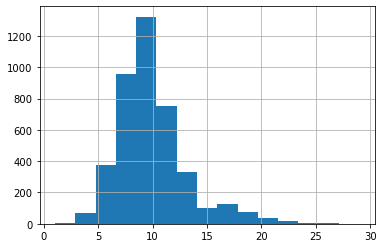

In [138]:
import matplotlib.pyplot as plt
abalone["Rings"].hist(bins=15)
plt.show()

### Data Preparation

In [9]:
X = abalone.drop("Rings", axis=1)
y = abalone["Rings"]

Use ``MinMaxScalar`` to normalize data.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
scaler.fit(X)
X_scaler = scaler.transform(X)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaler, y, test_size=0.2, random_state=12345
)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)

In [16]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [19]:
from sklearn.metrics import mean_squared_error
test_preds = knn_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
print('Test RMSE: ', np.sqrt(test_mse))

Test RMSE:  2.3861364161083864


We can improve the performance using cross validation ``GridSearchCV`` to select hyperparameters:

In [20]:
from sklearn.model_selection import GridSearchCV
params_grid = {"n_neighbors": range(1, 50), "p": [1,2]}
grid = GridSearchCV(KNeighborsRegressor(), params_grid,refit=True,verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END ................n_neighbors=1, p=1;, score=0.188 total time=   0.0s
[CV 2/5] END ................n_neighbors=1, p=1;, score=0.148 total time=   0.0s
[CV 3/5] END ................n_neighbors=1, p=1;, score=0.135 total time=   0.0s
[CV 4/5] END ................n_neighbors=1, p=1;, score=0.164 total time=   0.0s
[CV 5/5] END ................n_neighbors=1, p=1;, score=0.215 total time=   0.0s
[CV 1/5] END ................n_neighbors=1, p=2;, score=0.122 total time=   0.0s
[CV 2/5] END ................n_neighbors=1, p=2;, score=0.189 total time=   0.0s
[CV 3/5] END ................n_neighbors=1, p=2;, score=0.184 total time=   0.0s
[CV 4/5] END ................n_neighbors=1, p=2;, score=0.195 total time=   0.0s
[CV 5/5] END ................n_neighbors=1, p=2;, score=0.241 total time=   0.0s
[CV 1/5] END ................n_neighbors=2, p=1;, score=0.341 total time=   0.0s
[CV 2/5] END ................n_neighbors=2, p=1

[CV 5/5] END ...............n_neighbors=12, p=1;, score=0.545 total time=   0.0s
[CV 1/5] END ...............n_neighbors=12, p=2;, score=0.492 total time=   0.0s
[CV 2/5] END ...............n_neighbors=12, p=2;, score=0.530 total time=   0.0s
[CV 3/5] END ...............n_neighbors=12, p=2;, score=0.530 total time=   0.0s
[CV 4/5] END ...............n_neighbors=12, p=2;, score=0.547 total time=   0.0s
[CV 5/5] END ...............n_neighbors=12, p=2;, score=0.547 total time=   0.0s
[CV 1/5] END ...............n_neighbors=13, p=1;, score=0.503 total time=   0.0s
[CV 2/5] END ...............n_neighbors=13, p=1;, score=0.526 total time=   0.0s
[CV 3/5] END ...............n_neighbors=13, p=1;, score=0.529 total time=   0.0s
[CV 4/5] END ...............n_neighbors=13, p=1;, score=0.545 total time=   0.0s
[CV 5/5] END ...............n_neighbors=13, p=1;, score=0.554 total time=   0.0s
[CV 1/5] END ...............n_neighbors=13, p=2;, score=0.502 total time=   0.0s
[CV 2/5] END ...............

[CV 3/5] END ...............n_neighbors=23, p=2;, score=0.529 total time=   0.0s
[CV 4/5] END ...............n_neighbors=23, p=2;, score=0.545 total time=   0.0s
[CV 5/5] END ...............n_neighbors=23, p=2;, score=0.558 total time=   0.0s
[CV 1/5] END ...............n_neighbors=24, p=1;, score=0.507 total time=   0.0s
[CV 2/5] END ...............n_neighbors=24, p=1;, score=0.532 total time=   0.0s
[CV 3/5] END ...............n_neighbors=24, p=1;, score=0.531 total time=   0.0s
[CV 4/5] END ...............n_neighbors=24, p=1;, score=0.542 total time=   0.0s
[CV 5/5] END ...............n_neighbors=24, p=1;, score=0.556 total time=   0.0s
[CV 1/5] END ...............n_neighbors=24, p=2;, score=0.506 total time=   0.0s
[CV 2/5] END ...............n_neighbors=24, p=2;, score=0.523 total time=   0.0s
[CV 3/5] END ...............n_neighbors=24, p=2;, score=0.530 total time=   0.0s
[CV 4/5] END ...............n_neighbors=24, p=2;, score=0.544 total time=   0.0s
[CV 5/5] END ...............

[CV 3/5] END ...............n_neighbors=34, p=1;, score=0.519 total time=   0.0s
[CV 4/5] END ...............n_neighbors=34, p=1;, score=0.536 total time=   0.0s
[CV 5/5] END ...............n_neighbors=34, p=1;, score=0.548 total time=   0.0s
[CV 1/5] END ...............n_neighbors=34, p=2;, score=0.508 total time=   0.0s
[CV 2/5] END ...............n_neighbors=34, p=2;, score=0.523 total time=   0.0s
[CV 3/5] END ...............n_neighbors=34, p=2;, score=0.523 total time=   0.0s
[CV 4/5] END ...............n_neighbors=34, p=2;, score=0.537 total time=   0.0s
[CV 5/5] END ...............n_neighbors=34, p=2;, score=0.552 total time=   0.0s
[CV 1/5] END ...............n_neighbors=35, p=1;, score=0.506 total time=   0.0s
[CV 2/5] END ...............n_neighbors=35, p=1;, score=0.526 total time=   0.0s
[CV 3/5] END ...............n_neighbors=35, p=1;, score=0.517 total time=   0.0s
[CV 4/5] END ...............n_neighbors=35, p=1;, score=0.535 total time=   0.0s
[CV 5/5] END ...............

[CV 4/5] END ...............n_neighbors=45, p=1;, score=0.527 total time=   0.0s
[CV 5/5] END ...............n_neighbors=45, p=1;, score=0.543 total time=   0.0s
[CV 1/5] END ...............n_neighbors=45, p=2;, score=0.505 total time=   0.0s
[CV 2/5] END ...............n_neighbors=45, p=2;, score=0.518 total time=   0.0s
[CV 3/5] END ...............n_neighbors=45, p=2;, score=0.513 total time=   0.0s
[CV 4/5] END ...............n_neighbors=45, p=2;, score=0.529 total time=   0.0s
[CV 5/5] END ...............n_neighbors=45, p=2;, score=0.546 total time=   0.0s
[CV 1/5] END ...............n_neighbors=46, p=1;, score=0.501 total time=   0.0s
[CV 2/5] END ...............n_neighbors=46, p=1;, score=0.509 total time=   0.0s
[CV 3/5] END ...............n_neighbors=46, p=1;, score=0.509 total time=   0.0s
[CV 4/5] END ...............n_neighbors=46, p=1;, score=0.525 total time=   0.0s
[CV 5/5] END ...............n_neighbors=46, p=1;, score=0.541 total time=   0.0s
[CV 1/5] END ...............

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50), 'p': [1, 2]}, verbose=3)

In [21]:
grid.best_params_

{'n_neighbors': 19, 'p': 2}

In [23]:
test_preds_grid = grid.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)

print('Test RMSE: ', np.sqrt(test_mse))

Test RMSE:  2.1880618850148883
